# USING CLOSED LOOP DESIGNER

This notebook contains a case study of using SISOClosedLoopDesigner


In [1]:
import controlSBML as ctl
from controlSBML import constants as cn
from controlSBML import util

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sympy
import tellurium as te
ctl.__version__

'1.0.11'

In [2]:
TIMES = np.linspace(0, 20, 200)

# Models

## Linear

In [3]:
LINEAR_MDL = """
species S3

 -> S1; k0
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S1 = 0
S2 = 0
S3 = 0
k0 = 0
k1 = 1
k2 = 2
k3 = 3
"""

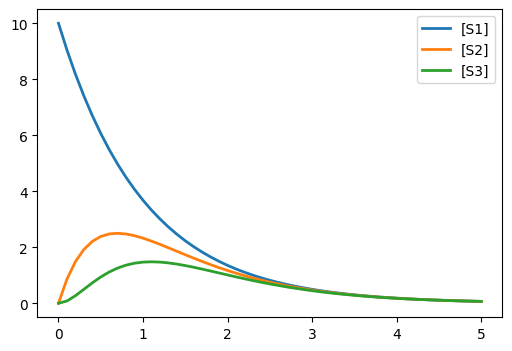

In [4]:
LINEAR_CTLSB = ctl.ControlSBML(LINEAR_MDL, input_names=["k0"], output_names=["S3"])
LINEAR_BLDR = LINEAR_CTLSB.makeSISOTransferFunctionBuilder(is_fixed_input_species=True)
selections = ["[S%d]" % (n+1) for n in range(3)]
selections.insert(0, "time")
LINEAR_CTLSB.roadrunner.reset()
LINEAR_CTLSB.roadrunner["S1"] = 10
data = LINEAR_CTLSB.roadrunner.simulate(selections=selections)
LINEAR_CTLSB.roadrunner.plot()

# System Identification

## Linear Model

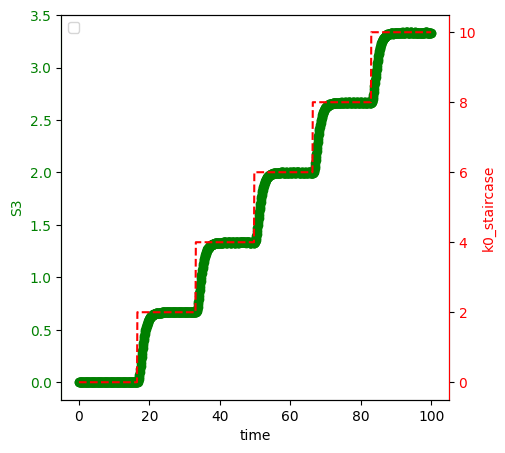

In [5]:
LINEAR_STAIRCASE = ctl.Staircase(initial_value=0, final_value=10, num_step=5)
response_ts = LINEAR_BLDR.makeStaircaseResponse(staircase=LINEAR_STAIRCASE, end_time=100)
_ = LINEAR_BLDR.plotStaircaseResponse(response_ts, figsize=(5,5))

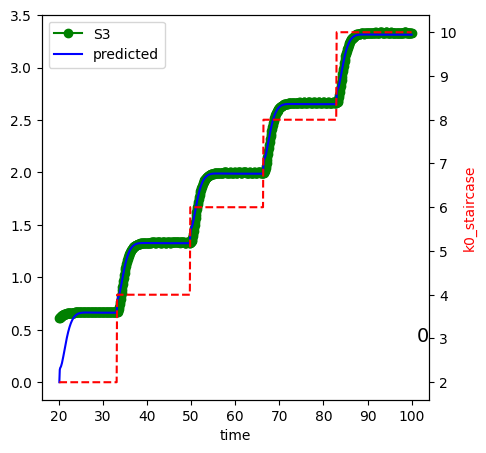

In [6]:
fitter_result = LINEAR_BLDR.fitTransferFunction(num_numerator=3, num_denominator=4, 
                                                      staircase=LINEAR_STAIRCASE, fit_start_time=20,
                                                start_time=0, end_time=100)
_ = LINEAR_BLDR.plotFitTransferFunction(fitter_result, figsize=(5,5))
LINEAR_TF = fitter_result.transfer_function

In [7]:
LINEAR_TF

TransferFunction(array([0.00048804, 0.0006561 , 0.00274681]), array([0.00035388, 0.00749284, 0.01358634, 0.0082879 ]))

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

In [8]:
siso = ctl.SISOClosedLoopSystem(LINEAR_CTLSB)
#siso.makePIDClosedLoopSystem(kp=0.5, ki=0.2, closed_loop_outputs=["S1", "S3"])
siso.makePIDClosedLoopSystem(kp=1, ki=1, closed_loop_outputs=["S1", "S3"])

In [9]:
end_time =50
result_ts = siso.makeResponse(times=TIMES, step_size=5)

Text(0, 0.5, 'S3')

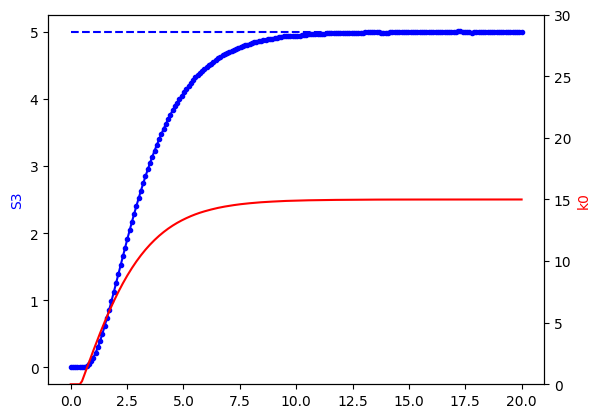

In [10]:
df = result_ts.copy()
times = np.array(df.index)/1000
plt.plot(TIMES, df["S3"], color="blue", marker=".")
ax = plt.gca()
ax.plot(TIMES, result_ts["reference"], linestyle="--", color = "blue")
ax2 = ax.twinx()
ax2.plot(TIMES, result_ts["S1"], color="red")
ax2.set_ylim([0, 30])
ax2.set_ylabel("k0", color="red")
ax.set_ylabel("S3", color="blue")
#_ = ax.set_ylim([0, 5000])

# Closed Loop Design and Evaluation

**BUG**
1. Why is designer so bad? I don't believe the poles for the design parameters.

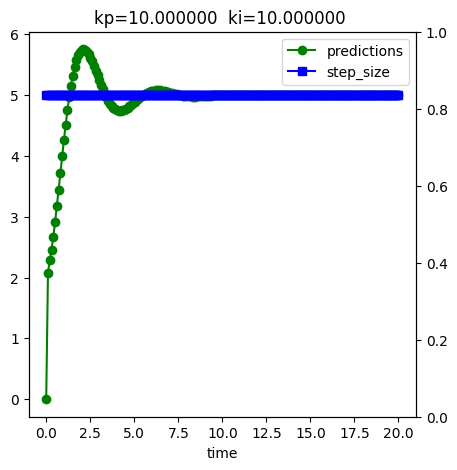

In [11]:
designer = ctl.SISOClosedLoopDesigner(LINEAR_TF, times=TIMES, step_size=5)
designer.design( kp=True, ki=True)
designer.set(kp=10, ki=10)
designer.plot(figsize=(5,5), times=TIMES)  # Have options for a period

In [12]:
designer.closed_loop_tf.poles()

array([-32.92426765+0.j        ,  -0.55361273+1.49035571j,
        -0.55361273-1.49035571j,  -0.9326914 +0.j        ])

In [13]:
designer.residual_rmse

0.3546701128781505

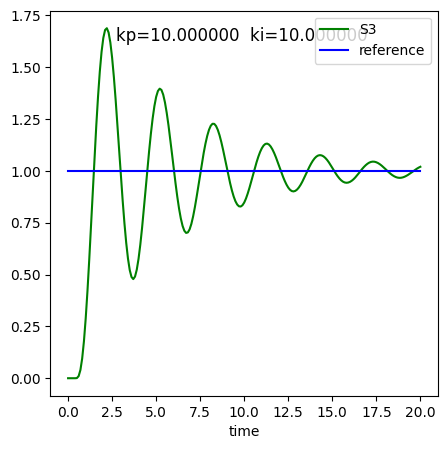

In [14]:
designer.evaluateNonlinearIOSystemClosedLoop(LINEAR_CTLSB, is_fixed_input_species=True,
                                             figsize=(5,5))

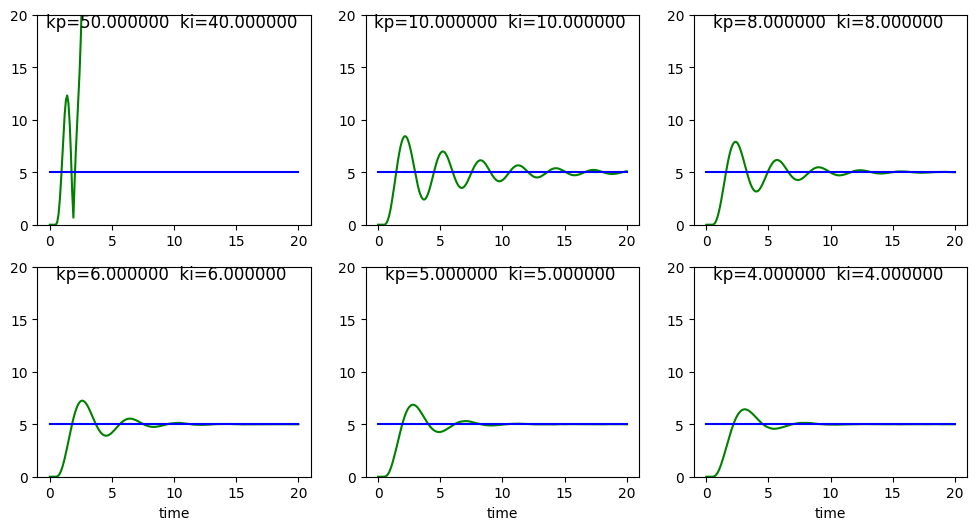

In [15]:
nrow = 2
ncol = 3
_, axes = plt.subplots(nrow, ncol)
icol = 0
irow = 0
for dct in [dict(kp=50, ki=40), dict(kp=10, ki=10), dict(kp=8, ki=8), dict(kp=6, ki=6), dict(kp=5, ki=5), dict(kp=4, ki=4)]:
    ax = axes[irow, icol]
    designer.set(**dct)
    if (icol == icol - 1) and (irow == irow - 1):
        is_plot = True
    else:
        is_plot = False
    designer.evaluateNonlinearIOSystemClosedLoop(LINEAR_CTLSB, times=TIMES, is_fixed_input_species=True,
                                             figsize=(12, 6), ylim=[0, 20], ax=ax, legend=False, is_plot=is_plot,
                                                step_size=5)
    if irow < nrow - 1:
        ax.set_xlabel("")
    if icol == ncol - 1:
        icol = 0
        irow += 1
    else:
        icol += 1

# Manual construction of feedback loop

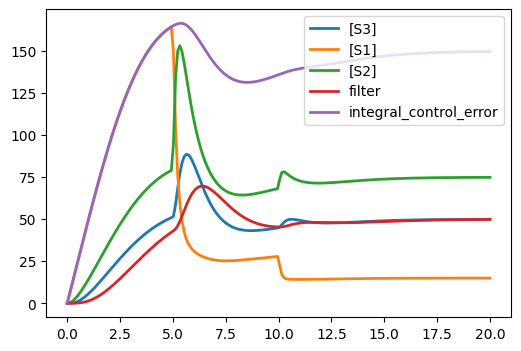

In [63]:
# Control k0
LINEAR_FEEDBACK = """

input := S3
filter' = -kf*filter + kf*input
control_error := reference - filter
integral_control_error' = control_error
control_input := kp*control_error + ki*integral_control_error
k0 := control_input
species S3
//
 -> S1; k0
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S1 = 0
S2 = 0
S3 = 0
#k0 = 1
k1 = 1
k2 = 2
k3 = 3
kp = 1
ki = 1
kf = 1
integral_control_error = 0
filter = 0
#
reference = 50

at (time >= 5): k1 = 5
at (time > 10): k1 = 10
"""
rr = te.loada(LINEAR_FEEDBACK)
data = rr.simulate(0, 20, 200)
rr.plot()

In [47]:
data

        time,     [S3],    [S1],    [S2],   filter, integral_control_error
 [[        0,        0,       0,       0,      0.5,                      0],
  [ 0.100503, 0.149406, 50.2092, 2.36299, 0.145206,                5.02092],
  [ 0.201005,  1.05848, 99.9492, 8.85099,  1.04407,                9.99492],
  [ 0.301508,  3.16795, 148.209, 18.6257,  3.14034,                14.8209],
  [  0.40201,  6.66301, 193.673, 30.8935,  6.62135,                19.3673],
  [ 0.502513,  11.5448, 234.936, 44.8796,  11.4898,                23.4936],
  [ 0.603015,  17.6812, 270.659, 59.8248,  17.6147,                27.0659],
  [ 0.703518,  24.8444, 299.687, 74.9938,  24.7691,                29.9687],
  [  0.80402,  32.7422, 321.127, 89.6921,  32.6611,                32.1127],
  [ 0.904523,  41.0428, 334.402, 103.285,  40.9593,                33.4402],
  [  1.00503,  49.3975, 339.279, 115.217,  49.3152,                33.9279],
  [  1.10553,  57.4606, 335.875, 125.028,  57.3829,                33.5875],
 